In [1]:
import sys
sys.path.append("../../src")
import os
import datetime
import pandas as pd
import numpy as np
from sindy_utils import library_size
from training import train_network, full_network, create_feed_dictionary
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle


c:\Users\Vasu\anaconda3\envs\sindy\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\Vasu\anaconda3\envs\sindy\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\Vasu\anaconda3\envs\sindy\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Users\Vasu\anaconda3\envs\sindy\lib\site-packages\tensorflow\python\frame

In [98]:
def extract_weights(final, name, chosen):
    network_weights=[final[k][name] for k in range(len(final)) if k in chosen]
    first_layer= np.mean([network_weights[k][0] for k in range(len(network_weights))], axis=0)
    second_layer= np.mean([network_weights[k][1] for k in range(len(network_weights))], axis=0)
    third_layer= np.mean([network_weights[k][2] for k in range(len(network_weights))], axis=0)
    weights=[first_layer,second_layer,third_layer]
    return weights
def find_mean_sindy_coeff(final, chosen):
    coefficient_list=[final[k].model['sindy_coefficients'] for k in range(len(final)) if k in chosen]
    ans=np.mean(coefficient_list, axis=0)
    return ans


def build_network_layers_transfer(exp, chosen={14, 5, 15}, var="encoder_biases"):
    temp_sum = None
    
    # Iterate over each chosen experiment number
    for exp_num in chosen:
        data = exp[exp_num].model[var]
        if temp_sum is None:
            temp_sum = [np.zeros_like(data_cell) for data_cell in data]
        # Accumulate the sum of the data arrays
        for j, data_cell in enumerate(data):
            temp_sum[j] += data_cell
    
    # Compute the mean by dividing the accumulated sum by the number of chosen experiments
    mean_array = [temp / len(chosen) for temp in temp_sum]
    
    return mean_array

def rolling_average_with_stride_optimized_v2(df, window_size, stride, allowed_clusters):
    results = []
    # Assuming the last column is categorical and the rest are numeric
    numeric_indices = list(range(2000))+[2001]  # Adjust if your indices start from 1 or another number
    categorical_col = df.columns[2000]  # Adjust based on zero-indexing

    for i in range(0, len(df) - window_size + 1, stride):
        window = df.iloc[i:i+window_size]
        aggregated_row = {}

        # Aggregate numeric columns
        poss=False
        # Aggregate the categorical column
        cell_types=set(window[categorical_col])
        if  cell_types in allowed_clusters:
            # If all elements belong to allowed clusters, compute mode, else NaN or other logic
            value_counts = window[categorical_col].value_counts()
            max_count_category = value_counts.idxmax()
            aggregated_row[categorical_col] = max_count_category
            poss=True
        
        if poss:
            aggregated_row.update(window.iloc[:, numeric_indices].mean().to_dict())

        results.append(aggregated_row)

    result_df = pd.DataFrame(results)
    return result_df
def split_data(data_dict, validation_ratio=0.2, seed=None):
    """
    Splits the data dictionary into training and validation sets.

    Parameters:
        data_dict (dict): The data dictionary with 'x' and 'dx' arrays.
        validation_ratio (float): The ratio of validation data (default: 0.2).
        seed (int): Seed for random number generator (optional).

    Returns:
        tuple: Two dictionaries: (training_dict, validation_dict).
    """
    

    x_array = data_dict['x']
    dx_array = data_dict['dx']
    class_ = data_dict['classes']

    # Get the number of samples
    num_samples = x_array.shape[0]
        
    # Shuffle the indices of the samples
    indices = np.arange(num_samples)
    np.random.shuffle(indices)

    # Calculate the size of the validation set
    validation_size = int(num_samples * validation_ratio)

    # Get the indices for validation and training sets
    validation_indices = indices[:validation_size]
    training_indices = indices[validation_size:]

    # Create the training and validation dictionaries
    training_dict = {
        'x': x_array[training_indices],
        'dx': dx_array[training_indices],
        'classes': class_[training_indices]
    }

    validation_dict = {
        'x': x_array[validation_indices],
        'dx': dx_array[validation_indices],
        'classes': class_[validation_indices]

    }

    return training_dict, validation_dict
def xavier_initializer(shape):
    """
    Xavier initializer for weights.
    
    Arguments:
        shape (tuple): Shape of the weight tensor.
    
    Returns:
        np.ndarray: Initialized weight tensor.
    """
    variance = 2.0 / (shape[0] + shape[1])  # Xavier variance calculation
    stddev = np.sqrt(variance)
    return np.random.normal(0, stddev, shape)

def build_network_layers(input_dim, output_dim, widths, name):
    """
    Construct one portion of the network (either encoder or decoder).
    Arguments:
        input (Tensor): 2D TensorFlow array, input to the network (shape is [?, input_dim]).
        input_dim (int): Integer, number of state variables in the input to the first layer.
        output_dim (int): Integer, number of state variables to output from the final layer.
        widths (List[int]): List of integers representing how many units are in each network layer.
        activation (function): TensorFlow activation function to be used at each layer.
        name (str): Prefix to be used in naming the TensorFlow variables.
    Returns:
        output (Tensor): TensorFlow array, output of the network layers (shape is [?, output_dim]).
        weights (List[Tensor]): List of TensorFlow arrays containing the network weights.
        biases (List[Tensor]): List of TensorFlow arrays containing the network biases.
    """
    weights = []
    last_width = input_dim
    for i, n_units in enumerate(widths):
        W = np.float32(xavier_initializer(shape=[last_width, n_units]))
        last_width = n_units
        weights.append(W)
    W = np.float32(xavier_initializer(shape=[last_width, output_dim]))
    weights.append(W)
    if name=="encoder":
        W = np.float32(xavier_initializer(shape=[last_width, output_dim]))
        weights.append(W)
    
    return weights
def coefficient_innit(library_dim, latent_dim):
    sindy_coefficients = xavier_initializer([library_dim,latent_dim])
    return np.float32(sindy_coefficients)
#### Transfer Learning Setup
class Experiment:
    def __init__(self):
        self.params = None
        self.exp_path = None
        self.drop_col_names = None 
        self.classes_to_drop = None
        self.params=None
        self.save_name=None
        self.model={}
        self.idx=0
        self.errors=None
        self.set_gen_cols()

    def find_errors(self, test_data):
        self.errors=Errors()
        self.errors.calculate_relative_errors(test_data, self.model, )
        self.errors.print_errors()

class Errors:
    def __init__(self):
        self.decoder_x_error = None  # Initialize with an appropriate default value
        self.decoder_dx_error = None  # Initialize with an appropriate default value
        self.sindy_dz_error = None  # Initialize with an appropriate default value

    def calculate_relative_errors(self, test_data, model):
        self.decoder_x_error = np.mean((test_data['x'] - model['x_decode'])**2) / np.mean(test_data['x']**2)
        self.decoder_dx_error = np.mean((test_data['dx'] - model['dx_decode'])**2) / np.mean(test_data['dx']**2)
        self.sindy_dz_error = np.mean((model['dz'] - model['dz_predict'])**2) / np.mean(model['dz']**2)
    def mult_errors(self):
        return self.decoder_x_error*self.decoder_dx_error*self.sindy_dz_error
    def print_errors(self):
        print('Decoder relative error: %f' % self.decoder_x_error)
        print('Decoder relative SINDy error: %f' % self.decoder_dx_error)
        print('SINDy relative error, z: %f' % self.sindy_dz_error)
class Experiments():
    def __init__ (self):
        self.experiments={}
    def add_experiment(self, num, exp):
        self.experiments[num] = exp
    def add_errors(self, num, test_data):
        self.experiments[num].find_errors(test_data)
    def find_top_k_exp(self):
        values=[]
        for i in range(len(self.experiments)):
            values.append(self.experiments[i].errors.mult_errors())
        return values

In [3]:
#Innitialize the parameter dictionary
params = {}

In [4]:
import scvelo as scv
scv.logging.print_version()

Running scvelo 0.2.5 (python 3.6.7) on 2024-09-16 00:36.


In [5]:
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.set_figure_params('scvelo')  # for beautified visualization

In [6]:
adata = scv.datasets.bonemarrow()


In [7]:
scv.utils.show_proportions(adata)
adata

Abundance of ['unspliced', 'spliced']: [0.48 0.52]


AnnData object with n_obs × n_vars = 5780 × 14319
    obs: 'clusters', 'palantir_pseudotime'
    uns: 'clusters_colors'
    obsm: 'X_tsne'
    layers: 'spliced', 'unspliced'

In [8]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)


Filtered out 7837 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.


In [9]:
try:
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
except Exception as e:
    print(e,"Reinstalling the library...")
    %pip install importlib.metadata
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)


computing neighbors
No module named 'importlib.metadata' Reinstalling the library...
Note: you may need to restart the kernel to use updated packages.
computing neighbors
    finished (0:00:06) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [10]:
scv.tl.velocity_graph(adata)
scv.tl.velocity_pseudotime(adata)

computing velocities


    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/16 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:28) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 3 regions of root cells and 2 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


In [11]:
adata

AnnData object with n_obs × n_vars = 5780 × 2000
    obs: 'clusters', 'palantir_pseudotime', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime'
    var: 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'clusters_colors', 'pca', 'neighbors', 'velocity_params', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'X_tsne', 'X_pca'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu', 'velocity', 'variance_velocity'
    obsp: 'distances', 'connectivities'

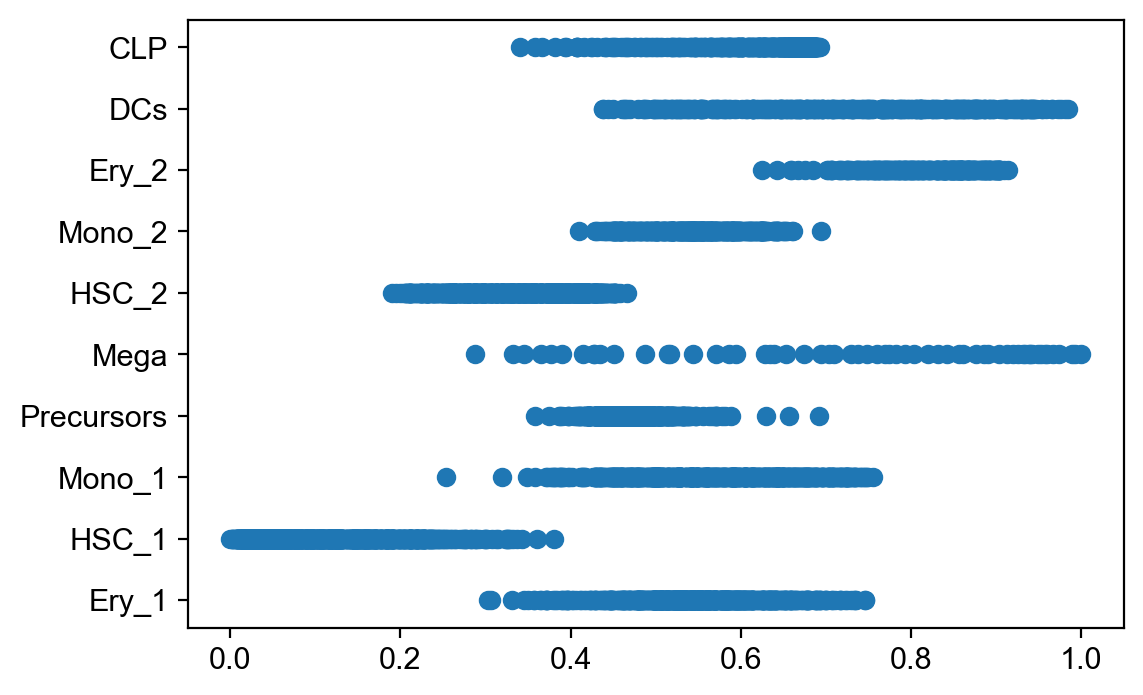

In [12]:
plt.scatter(adata.obs['palantir_pseudotime'],adata.obs['clusters'])

In [13]:
target=list(adata.var_names)+['clusters']
target_dict={i:target[i] for i in range(2001)}
index=np.asarray(adata.obs['palantir_pseudotime'].argsort())

In [14]:
adata.obs.iloc[index,0].value_counts() #clusters

HSC_1         1118
HSC_2          984
Ery_1          742
Mono_1         724
Precursors     666
CLP            488
Mono_2         429
DCs            303
Ery_2          265
Mega            61
Name: clusters, dtype: int64

In [15]:
count_matrix=adata.X.toarray()[index,:]
clusters = np.expand_dims(np.asarray(adata.obs.iloc[index, 0]), axis=-1)


In [16]:
index=np.asarray(adata.obs['velocity_pseudotime'].argsort())
res=np.concatenate([count_matrix,clusters],axis=1)
df_bone_marrows=pd.DataFrame.from_records(res)
df_bone_marrows['Time']=range(1, 1+len(df_bone_marrows))
df_bone_marrows=df_bone_marrows.rename(columns=target_dict)

In [17]:
df_bone_marrows['clusters'].value_counts()

HSC_1         1118
HSC_2          984
Ery_1          742
Mono_1         724
Precursors     666
CLP            488
Mono_2         429
DCs            303
Ery_2          265
Mega            61
Name: clusters, dtype: int64

In [18]:
#Parameters used for defining the preprocessing over the dataset

params['data_path'] = os.getcwd() + '/'
params['avg']='rolling' #'rolling' average keeps an overlap while taking the average. .'grouped' average doesn't keep an overlap.
params['window_size']=4#The window length of averaging
params['normalized']=False #Boolean, if True, the data is scaled with mean and standard deviation (x-mu)/sigma
params['diff']='finite_diff' #Only supports finite difference for calculating the derivative for now. Other methods can be added
params['time_step']='unit' #Supports 'unit' and 'dpt_time' for calculating the derivative for now.
params['seed']= 42 #Random seed for reproducibility
params['window_size'] =4
params['stride']=2
np.random.seed(params['seed'])


In [19]:
allowed_pairs=[['HSC_1','HSC_2'],
['HSC_2','Precursors'],
['Precursors','DCs'],
['Precursors','Mono_1'],
['Mono_1','Mono_2'],
['HSC_2','Mono_2'],
['Mono_1','Precursors'],
# ['Mega','Ery_1'],
['Ery_1','Ery_2 '],
['HSC_2','Mono_1']]

In [20]:
cluster_names=[]
for x in clusters:
    if x not in cluster_names:
        cluster_names.append(x)
close_pairs=cluster_names+[set(x) for x in allowed_pairs]
allowed_clusters=[set(pairs) for pairs in close_pairs]
allowed_clusters.remove({'CLP'})
allowed_clusters.remove({'Mega'})
# allowed_clusters.remove({'Ery_1'})
# allowed_clusters.remove({'Ery_2'})
rolling_avg = rolling_average_with_stride_optimized_v2(df_bone_marrows, params['window_size'], params['stride'],allowed_clusters) # Rolling average
cleaned_df = rolling_avg.dropna(how='all')



In [21]:
cleaned_df

,clusters,CCNL2,NADK,CEP104,RERE,SLC2A5,CLSTN1,TMCO4,LUZP1,RUNX3,...,FMR1,MTMR1,VAMP7,UTY,TTTY14,KDM5D,ZFY,TTTY15,USP9Y,Time
0,HSC_1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.397072,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.5
1,HSC_1,0.000000,0.000000,0.000000,0.000000,0.279212,0.000000,0.407820,0.279212,0.312109,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.5
2,HSC_1,0.000000,0.000000,0.000000,0.266244,0.279212,0.259492,0.407820,0.545456,0.578353,...,0.000000,0.000000,0.259492,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.5
3,HSC_1,0.000000,0.000000,0.000000,0.266244,0.000000,0.259492,0.000000,0.538803,0.266244,...,0.000000,0.000000,0.259492,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.5
4,HSC_1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.272559,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.284032,0.000000,0.284032,10.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2853,Ery_2,0.160089,0.000000,0.120767,0.056779,0.000000,0.160281,0.057069,0.202470,0.000000,...,0.057069,0.000000,0.145123,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5708.5
2854,Ery_2,0.160089,0.000000,0.119383,0.108387,0.000000,0.160281,0.057069,0.000000,0.000000,...,0.057069,0.000000,0.108678,0.000000,0.062314,0.000000,0.000000,0.051608,0.051608,5710.5
2869,DCs,0.133820,0.099258,0.000000,0.000000,0.000000,0.000000,0.000000,0.099258,0.099258,...,0.000000,0.099258,0.265144,0.233078,0.000000,0.280444,0.133820,0.170117,0.000000,5740.5
2870,DCs,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.265144,0.000000,0.000000,0.280444,0.000000,0.000000,0.000000,5742.5


In [22]:
normalized=cleaned_df #normalize the data
col_names=normalized.columns.tolist()

dx=pd.DataFrame()
for names in col_names:
    if params['diff']=='finite_diff' and names!='clusters' and names!='Time':
        dx[names]=(np.gradient(normalized[names],normalized['Time'])) #Finite difference method using np.gradient
normalized.drop(columns=['Time'], inplace=True) #dropping Time column as it is not needed in the training part

In [26]:
normalized

,clusters,CCNL2,NADK,CEP104,RERE,SLC2A5,CLSTN1,TMCO4,LUZP1,RUNX3,...,FAM122C,FMR1,MTMR1,VAMP7,UTY,TTTY14,KDM5D,ZFY,TTTY15,USP9Y
0,HSC_1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.397072,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,HSC_1,0.000000,0.000000,0.000000,0.000000,0.279212,0.000000,0.407820,0.279212,0.312109,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,HSC_1,0.000000,0.000000,0.000000,0.266244,0.279212,0.259492,0.407820,0.545456,0.578353,...,0.000000,0.000000,0.000000,0.259492,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,HSC_1,0.000000,0.000000,0.000000,0.266244,0.000000,0.259492,0.000000,0.538803,0.266244,...,0.000000,0.000000,0.000000,0.259492,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,HSC_1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.272559,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.284032,0.000000,0.284032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2853,Ery_2,0.160089,0.000000,0.120767,0.056779,0.000000,0.160281,0.057069,0.202470,0.000000,...,0.056779,0.057069,0.000000,0.145123,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2854,Ery_2,0.160089,0.000000,0.119383,0.108387,0.000000,0.160281,0.057069,0.000000,0.000000,...,0.056779,0.057069,0.000000,0.108678,0.000000,0.062314,0.000000,0.000000,0.051608,0.051608
2869,DCs,0.133820,0.099258,0.000000,0.000000,0.000000,0.000000,0.000000,0.099258,0.099258,...,0.000000,0.000000,0.099258,0.265144,0.233078,0.000000,0.280444,0.133820,0.170117,0.000000
2870,DCs,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.265144,0.000000,0.000000,0.280444,0.000000,0.000000,0.000000


In [27]:
import pandas as pd

# Example DataFrame setup
data = normalized['clusters']
# normalized = pd.DataFrame(data)

# Create dummies
dummy_df = pd.get_dummies(normalized['clusters'])

# Convert to numpy array
class_ = dummy_df.values

# Get column names from dummy DataFrame, which are the cluster names
columns = dummy_df.columns.tolist()

# Create a mapping from array index to cluster name
index_to_cluster = {i: name for i, name in enumerate(columns)}

# Display the mapping
index_to_cluster


{0: 'DCs',
 1: 'Ery_1',
 2: 'Ery_2',
 3: 'HSC_1',
 4: 'HSC_2',
 5: 'Mono_1',
 6: 'Mono_2',
 7: 'Precursors'}

In [29]:
class_=pd.get_dummies(normalized['clusters']).values
x=normalized.values #getting the values from the normalized dataframe so that it can be used for training
dx=dx.values #getting the values from the dx dataframe so that it can be used for training

In [31]:
training_dict={'x':x, 'dx':dx, 'classes':class_} #also add one hot encoding as 'class
training_data, validation_data = split_data(training_dict, validation_ratio=0.055, seed=params['seed']) #split the data into training and validation sets
print(training_data['x'].shape, training_data['dx'].shape, training_data['classes'].shape) #verify the shapes of the training data
print(validation_data['x'].shape, validation_data['dx'].shape,validation_data['classes'].shape) #verify the shapes of the validation data

(1172, 2000) (1172, 2000) (1172, 8)
(68, 2000) (68, 2000) (68, 8)


In [72]:
transfer_root_path='Pancreas[512, 32][100, 0.01, 0.1, 0.01, 1e-06, 6, 0.1, 0, [8]]0.001'#Name of the directory of experiment
data_path = '../Pancreas'

save_name_list=[]
experiments=Experiments()
#folder_name = 'aePancreas[512, 32][1, 0.01, 0.1, 0.007, 2e-07]0.001'+'/'
#folder_name = 'aePancreas[512, 32][5, 0.01, 0.1, 0.005, 9e-08]0.001'+'/'
experimet_dir=os.path.join(data_path,transfer_root_path)
for name in os.listdir(experimet_dir):
        name_list=name.split(".")
        if(len(name_list)>1 and name_list[1]=="index"):
            save_name_list.append(name_list[0])
print(len(save_name_list)) 

save_name=save_name_list[0]
params_path = os.path.join(experimet_dir, save_name + '_params.pkl')

# Load the pickle file
params = pickle.load(open(params_path, 'rb'))

# Load the pickle file
save_name= os.path.join(experimet_dir,params['save_name'] )
tf.reset_default_graph()
#Load the network

autoencoder_network = full_network(params)
learning_rate = tf.placeholder(tf.float32, name='learning_rate')
saver = tf.train.Saver(var_list=tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES))

tensorflow_run_tuple = ()
for key in autoencoder_network.keys():
    tensorflow_run_tuple += (autoencoder_network[key],)
# Run the trained TensorFlow model on the test data

Error_dict={}
ans={}
stride_len=params['stride']
for exp_number, save_name in enumerate(save_name_list):
    experiment=Experiment()
    print(exp_number)
    #add the folder name where the result is present
    #add the model save name
    experiment.params = pickle.load(open(os.path.join(experimet_dir,save_name + '_params.pkl'), 'rb'))
    experiment.save_name= os.path.join(experimet_dir,experiment.params['save_name'])
    tf.reset_default_graph()

    autoencoder_network = full_network(experiment.params)
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    saver = tf.train.Saver(var_list=tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES))
    # temp_models={}fmodel
    
    tensorflow_run_tuple = ()
    new_keys={}
    # temp_models={}
    for key in autoencoder_network.keys():
        if key not in ['class_labels', 'class_score', 'classifier_weights', 'classifier_biases','classes']:
            new_keys[key]=0
            tensorflow_run_tuple += (autoencoder_network[key],)
    with tf.Session() as sess:
        # Initialize global variables and restore the saved model
        sess.run(tf.global_variables_initializer())
        saver.restore(sess, experiment.save_name)
        
        # Create a feed dictionary for the test data
        test_dictionary = create_feed_dictionary(training_dict, experiment.params)
        test_dictionary.pop("classes:0")
        # Execute the TensorFlow operations on the test data
        tf_results = sess.run(tensorflow_run_tuple, feed_dict=test_dictionary)
    idx=0
    for i, key in enumerate(autoencoder_network.keys()):
        if key not in ['class_labels', 'class_score', 'classifier_weights', 'classifier_biases','classes']:
           experiment.model[key]=tf_results[idx]
           idx+=1
    experiment.idx=exp_number
    experiment.idx=exp_number
    experiments.add_experiment(exp_number, experiment)
    print("Errors")
    experiments.add_errors(exp_number, training_dict)

2
0
INFO:tensorflow:Restoring parameters from ../Pancreas\Pancreas[512, 32][100, 0.01, 0.1, 0.01, 1e-06, 6, 0.1, 0, [8]]0.001\2024_09_16_00864329
Errors
Errors
Decoder relative error: 0.941810
Decoder relative SINDy error: 68.344270
SINDy relative error, z: 21645.230469
1
INFO:tensorflow:Restoring parameters from ../Pancreas\Pancreas[512, 32][100, 0.01, 0.1, 0.01, 1e-06, 6, 0.1, 0, [8]]0.001\2024_09_16_01131185
Errors
Errors
Decoder relative error: 0.950215
Decoder relative SINDy error: 26.923217
SINDy relative error, z: 4551.474609


In [73]:
order=np.argsort(experiments.find_top_k_exp())
good_exp=order[:6]

In [81]:
params['encoder_weights'][0].shape

(512,)

In [91]:
experiments.experiments[0].model['encoder_weights'][0].shape

(2000, 512)

In [97]:
latent_dim=6
print(latent_dim)
params['input_dim'] = 2000
params['latent_dim'] =latent_dim
params['model_order'] = 1
params['poly_order'] = 2
params['include_sine'] = True
params['include_constant']=True
#The below inclide parameters have only been simulated for model_order 1 for now
if params['model_order']==1:
    params['include_tan']=False
    params['include_log']=False #this can be modified later such that the domain restirctions of log doesnt become a problem. For now it is kept to false.
    params['include_exp']=True
    params['include_reciprocal_func']=True
else:
    params['include_tan']=False
    params['include_log']=False
    params['include_exp']=True
    params['include_reciprocal_func']=False
params['library_dim'] = library_size(n=params['latent_dim'], poly_order=params['poly_order'], use_sine=params['include_sine'], include_constant=params['include_constant'],use_tan=params['include_tan'],use_log=params['include_log'],use_exp=params['include_exp'],use_reciprocal=params['include_reciprocal_func'])



# sequential thresholding parameters
params['sequential_thresholding'] = True
params['coefficient_threshold'] = 0.1
params['threshold_frequency'] = 500
params['coefficient_mask'] = np.ones((params['library_dim'], params['latent_dim']))

# loss function weighting
params['loss_weight_decoder'] = 10
params['loss_weight_sindy_z'] = 1e-2
params['loss_weight_sindy_x'] = 1e-1
params['loss_weight_sindy_regularization'] =1e-2
params['autoencoder_regularization']=1e-6
params['shap_weight']=0

params['weights']=[params['loss_weight_decoder'],params['loss_weight_sindy_z'],params['loss_weight_sindy_x'],params['loss_weight_sindy_regularization'],params['autoencoder_regularization'], params['latent_dim'],params['coefficient_threshold'],params['shap_weight']]
if params['model']=='vae':
    params['beta']=0.3
    params['weights']=params['weights']+[params['beta']]


params['activation'] = 'relu'
params['widths'] = [512,32]
# training parameters
params['epoch_size'] = training_data['x'].shape[0]
params['batch_size'] = training_data['x'].shape[0]
params['learning_rate'] =1e-3
params['print_progress'] = True
params['print_frequency'] = 50

params['num_classes']=8
# training time cutoffs
params['max_epochs'] = 1
params['refinement_epochs'] =1
params['terms']=4*latent_dim+6 # put as None if the training should go for entire epoch defined. If the number of active terms go below this, the training stops


#classifier parameters
params['classify']=True
params['classifier_widths']=[8]
params['weights']=params['weights']+[params['classifier_widths']]
params['loss_class']=1
num_experiments = 1

df = pd.DataFrame()
for i in range(num_experiments):
    print('EXPERIMENT %d' % i)
    chosen=random.sample(list(good_exp), 2)
    params['encoder_weights']=build_network_layers_transfer(experiments.experiments,chosen, "encoder_weights")
    params['decoder_weights']=build_network_layers_transfer(experiments.experiments,chosen, "decoder_weights")
    params['encoder_biases']=build_network_layers_transfer(experiments.experiments,chosen, "encoder_biases")
    params['decoder_biases']=build_network_layers_transfer(experiments.experiments,chosen, "decoder_biases")
    params['classifier_weights']=build_network_layers( params['latent_dim'], params['num_classes'], params['classifier_widths'], 'encoder')
    params['coefficient_mask'] = np.ones((params['library_dim'], params['latent_dim']))
    
    params['folder'] = params['model']+'transfer_learning_better_time_withoutMega'+str(params['widths'])+str(params['weights'])+str(params['learning_rate'])
    params['save_name']=datetime.datetime.now().strftime("%Y_%m_%d_%H%f")
    params['coefficient_initialization'] = 'specified'
    params['init_coefficients']=np.asarray(find_mean_sindy_coeff(experiments.experiments,chosen))

    # Create a save folder if it doesn't exist
    save_folder = os.path.join(params['data_path'], params['folder'])
    params['save_folder']=save_folder+"\\"
    os.makedirs(save_folder, exist_ok=True)
    os.chdir(save_folder)
    tf.reset_default_graph()

    # Train the network and obtain results
    results_dict = train_network(training_data, validation_data, params)
    df = df.append({**results_dict, **params}, ignore_index=True)

# Change back to the original data path
os.chdir(params['data_path'])    
# Save the DataFrame to a pickle file with a timestamped filename
df.to_pickle('experiment_results_' + datetime.datetime.now().strftime("%Y%m%d%H%M") + '.pkl')

6
EXPERIMENT 0
0 3
1 3
2 3
0 3
1 3
2 3
0 3
1 3
2 3
0 3
1 3
2 3
0 3
1 3
2 3
0 3
1 3
2 3
0 3
1 3
2 3
0 3
1 3
2 3
TRAINING
Legend
['Combined loss', 'Reconstruction loss', 'SINDy_z loss', 'SINDy_x loss', 'Sindy Regularisation- L1 Norm', 'Autoencoder weights- L1 Norm', 'Classification Loss']
Epoch 0
Training loss 1.4994776248931885, (0.06640166, 11.219751, 0.005073384, 0.4751153, 33013.61, 0.6849914)
Validation loss 1.5090253353118896, (0.06725119, 11.171628, 0.005271741, 0.4751153, 33013.61, 0.68650526)
decoder loss ratio: 0.984122, decoder SINDy loss  ratio: 2.154146, SINDy z loss ratio: 67818.062500
REFINEMENT
Epoch 0
Training loss 1.4599096775054932, (0.0648022, 9.680247, 0.0072955284, 0.47524902, 32350.607, 0.682005)
Validation loss 1.4711271524429321, (0.06574763, 9.598198, 0.007929876, 0.47524902, 32350.607, 0.6845253)
decoder loss ratio: 0.962120, decoder SINDy loss  ratio: 3.240316, SINDy z loss ratio: 58266.453125


KeyError: 'loss_class'

In [ ]:
latent_dim=6
print(latent_dim)
params['input_dim'] = 2000
params['latent_dim'] =latent_dim
params['model_order'] = 1
params['poly_order'] = 2
params['include_sine'] = True
params['include_constant']=True
#The below inclide parameters have only been simulated for model_order 1 for now
if params['model_order']==1:
    params['include_tan']=False
    params['include_log']=False #this can be modified later such that the domain restirctions of log doesnt become a problem. For now it is kept to false.
    params['include_exp']=True
    params['include_reciprocal_func']=True
else:
    params['include_tan']=False
    params['include_log']=False
    params['include_exp']=True
    params['include_reciprocal_func']=False
params['library_dim'] = library_size(n=params['latent_dim'], poly_order=params['poly_order'], use_sine=params['include_sine'], include_constant=params['include_constant'],use_tan=params['include_tan'],use_log=params['include_log'],use_exp=params['include_exp'],use_reciprocal=params['include_reciprocal_func'])



# sequential thresholding parameters
params['sequential_thresholding'] = True
params['coefficient_threshold'] = 0.1
params['threshold_frequency'] = 500
params['coefficient_mask'] = np.ones((params['library_dim'], params['latent_dim']))

# loss function weighting
params['loss_weight_decoder'] = 10
params['loss_weight_sindy_z'] = 1e-2
params['loss_weight_sindy_x'] = 1e-1
params['loss_weight_sindy_regularization'] =1e-2
params['autoencoder_regularization']=1e-6
params['shap_weight']=0

params['weights']=[params['loss_weight_decoder'],params['loss_weight_sindy_z'],params['loss_weight_sindy_x'],params['loss_weight_sindy_regularization'],params['autoencoder_regularization'], params['latent_dim'],params['coefficient_threshold'],params['shap_weight']]
if params['model']=='vae':
    params['beta']=0.3
    params['weights']=params['weights']+[params['beta']]


params['activation'] = 'relu'
params['widths'] = [512,32]
# training parameters
params['epoch_size'] = training_data['x'].shape[0]
params['batch_size'] = training_data['x'].shape[0]
params['learning_rate'] =1e-3
params['print_progress'] = True
params['print_frequency'] = 50

params['num_classes']=8
# training time cutoffs
params['max_epochs'] = 1
params['refinement_epochs'] =1
params['terms']=4*latent_dim+6 # put as None if the training should go for entire epoch defined. If the number of active terms go below this, the training stops


#classifier parameters
params['classify']=True
params['classifier_widths']=[8]
params['weights']=params['weights']+[params['classifier_widths']]
params['loss_class']=1
num_experiments = 1

df = pd.DataFrame()
for i in range(num_experiments):
    print('EXPERIMENT %d' % i)
    chosen=random.sample(list(good_exp), 2)
    params['encoder_weights']=build_network_layers_transfer(experiments.experiments,chosen, "encoder_weights")
    params['decoder_weights']=build_network_layers_transfer(experiments.experiments,chosen, "decoder_weights")
    params['encoder_biases']=build_network_layers_transfer(experiments.experiments,chosen, "encoder_biases")
    params['decoder_biases']=build_network_layers_transfer(experiments.experiments,chosen, "decoder_biases")
    params['classifier_weights']=build_network_layers( params['latent_dim'], params['num_classes'], params['classifier_widths'], 'encoder')
    params['coefficient_mask'] = np.ones((params['library_dim'], params['latent_dim']))
    
    params['folder'] = params['model']+'transfer_learning_better_time_withoutMega'+str(params['widths'])+str(params['weights'])+str(params['learning_rate'])
    params['save_name']=datetime.datetime.now().strftime("%Y_%m_%d_%H%f")
    params['coefficient_initialization'] = 'specified'
    params['init_coefficients']=np.asarray(find_mean_sindy_coeff(experiments.experiments,chosen))

    # Create a save folder if it doesn't exist
    save_folder = os.path.join(params['data_path'], params['folder'])
    params['save_folder']=save_folder+"\\"
    os.makedirs(save_folder, exist_ok=True)
    os.chdir(save_folder)
    tf.reset_default_graph()

    # Train the network and obtain results
    results_dict = train_network(training_data, validation_data, params)
    df = df.append({**results_dict, **params}, ignore_index=True)

# Change back to the original data path
os.chdir(params['data_path'])    
# Save the DataFrame to a pickle file with a timestamped filename
df.to_pickle('experiment_results_' + datetime.datetime.now().strftime("%Y%m%d%H%M") + '.pkl')